# Overview

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pmdarima.arima import auto_arima
from gensim.models import KeyedVectors
import spacy
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram
from pylab import rcParams
import re
from datetime import date
from catboost import Pool, CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import holidays
from itertools import product


rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
item_categories = pd.read_csv("./data/item_categories.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [7]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [8]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [9]:
# Check missing values
print("items:\n" + str(items.isna().sum()) + "\n")
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

items:
item_name           0
item_id             0
item_category_id    0
dtype: int64

train:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

test:
ID         0
shop_id    0
item_id    0
dtype: int64



# Preprocessing

## train

In [10]:
print(f"The number of shops: {train['shop_id'].unique().shape[0]}")
print(f"The number of items: {train['item_id'].unique().shape[0]}")

The number of shops: 60
The number of items: 21807


### Format: date

In [4]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

### Anomalies in item_price column

In [12]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [13]:
train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [5]:
missing_price = train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973) & (train['item_price'] > 0)]
train.loc[train['item_price'] < 0, "item_price"] = missing_price['item_price'].mean()

In [15]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Anomalies in item_cnt_day column

In [16]:
negative_train = train[train['item_cnt_day'] < 0]

In [17]:
# Statistics: item_price
train['item_price'].describe()

count    2.935849e+06
mean     8.908537e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [18]:
# Statistics: item_price of records with item_cnt_day < 0
negative_train['item_price'].describe()

count     7356.000000
mean      1442.945623
std       2419.680132
min          0.500000
25%        349.000000
50%        799.000000
75%       1699.000000
max      33490.000000
Name: item_price, dtype: float64

In [6]:
train['item_cnt_day'] = np.where(train['item_cnt_day'] < 0, 0, train['item_cnt_day'])

### Date aggregation

In [7]:
train_g = train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index()
train_g

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


## test

In [20]:
print(f"The number of shops in train data: {train['shop_id'].unique().shape[0]}")
print(f"The number of shops in test data: {test['shop_id'].unique().shape[0]}")

The number of shops in train data: 60
The number of shops in test data: 42


In [21]:
print("Items appear in test set but not in train set:")
len(set(test["item_id"].unique().tolist()) - set(train["item_id"].unique().tolist()))

Items appear in test set but not in train set:


363

## shop

According to a [post](https://www.kaggle.com/code/gordotron85/future-sales-xgboost-top-3#Introduction]) in the kaggle discussion, some shops are similar to each other possibly due to re-opening. 

In [8]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

# Feature Engineering

## Text Embeddings

In [9]:
ru_model = KeyedVectors.load_word2vec_format('../wiki.ru.vec')

In [10]:
def extract_feature(text_col):
    features = list()
    len_lst = list()
    nlp = spacy.load("ru_core_news_lg")
    fail_count = 0
    
    for i in tqdm(range(text_col.shape[0])):
        one_feature = list()
        tokens = nlp (text_col[i])
        for token in tokens:
            try:
                one_feature.append(ru_model.get_vector(token.text))
            except:
                continue
        if len(one_feature) > 0:
            one_feature = np.stack(one_feature).flatten()
        else:
            one_feature = np.zeros(300)
            fail_count += 1
        features.append(one_feature)
        len_lst.append(one_feature.shape[0])
        
    med = int(pd.Series(len_lst).max())
    print(f"Max: {med}")
    feature_tp = list()
    for item in features:
        if item.shape[0] < med:
            item = np.concatenate([item, np.zeros(med - item.shape[0])])
        else:
            item = item[:med]
        feature_tp.append(item)
    
    print(f"Failed: {fail_count}")
    features = np.stack(feature_tp)
    return features

In [11]:
def encoding_cate(ser, num):
    ser_df = ser.value_counts().to_frame('count').reset_index()
    ser_df = ser_df.loc[ser_df['count'] > num, 'index']
    print(f"The number of classes: {ser_df.shape[0] + 1}")
    ser_df = pd.DataFrame({"cate": ser_df.tolist(), "index": list(range(ser_df.shape[0], 0, -1))})
    return ser.to_frame('cate').merge(ser_df, on='cate', how='left').fillna(0)['index'].astype(int)

### item_categories

In [12]:
item_categories_feature = extract_feature(item_categories['item_category_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 187.16it/s]

Max: 1800
Failed: 1


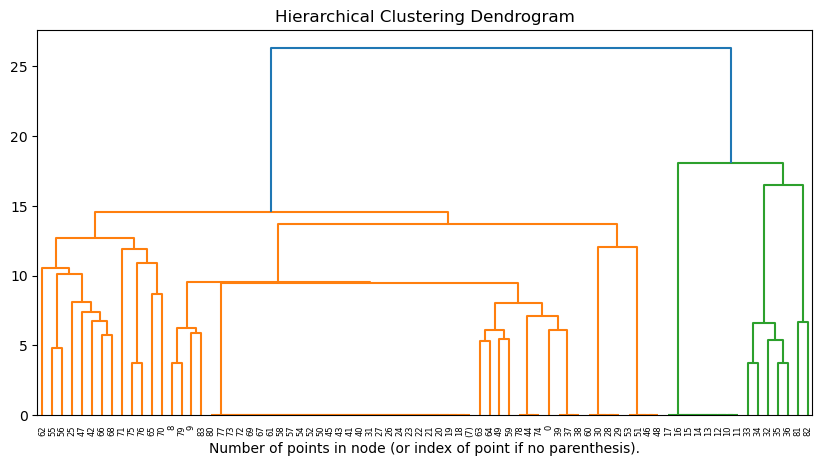

In [13]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(item_categories_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [14]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 17
Check the shape of labels: 84
Labels: [ 2  6  6  6  6  6  6  6  5  5 11 11 11 11 11 11 11 11  6  6  6  6  6  6
  6 15  6  6 16 16 16  6  3  3  3  3  3  2  2  2  6  6  0  6  2  6  9  0
  9  7  6  9  6  9  6 12 12  6  6  7 16  6 10  7  7 14  0  6  0  6 13  8
  6  6  2  4  4  6  2  5  6  1  1  5]


In [15]:
item_categories['item_category_te'] = clustering.labels_
item_categories = item_categories.drop(columns=['item_category_name'])
item_categories

,item_category_id,item_category_te
0,0,2
1,1,6
2,2,6
3,3,6
4,4,6
...,...,...
79,79,5
80,80,6
81,81,1
82,82,1


In [16]:
cols = ["category_1", "category_2"]
item_categories_tfidf = pd.read_csv("./sales/_item_categories.csv", 
                                    usecols=["item_category_id", "category_1", "category_2"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(item_categories_tfidf[col].unique()))
    item_categories_tfidf = item_categories_tfidf.replace({col:value_map})

item_categories_tfidf.head()

,item_category_id,category_1,category_2
0,0,0,0
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4


### shops

In [17]:
shops_feature = extract_feature(shops['shop_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 263.82it/s]

Max: 1500
Failed: 2


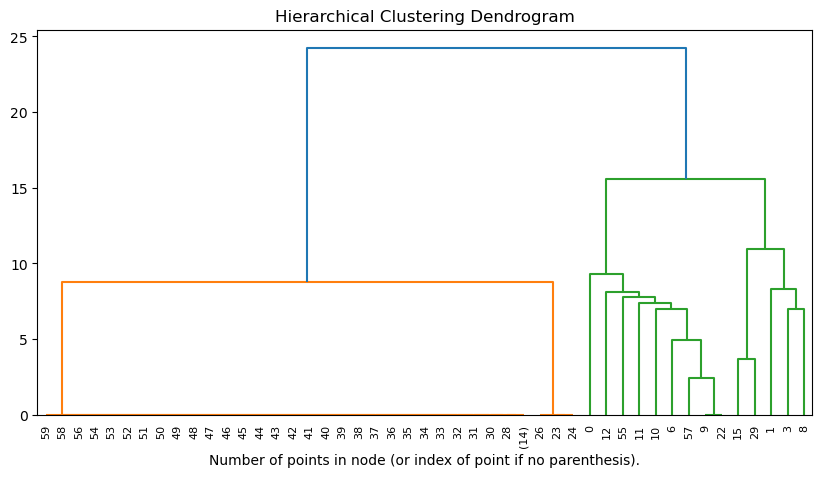

In [18]:
clustering = AgglomerativeClustering(distance_threshold=5, n_clusters=None).fit(shops_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [19]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 12
Check the shape of labels: 60
Labels: [ 9  6  5 11  5  5  0  5  8  0 10  4  7  5  5  1  5  5  5  5  5  5  0  2
  2  5  2  5  5  1  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  3  5  0  5  5]


In [20]:
shop_name = shops['shop_name'].str.split(pat=' ', n=2)
def remove_stopping_words(lst):
    new_lst = list()
    for i in lst:
        i = i.strip(',?!"()')
        i = re.sub('"', '', i)
        i = re.sub('\(', '', i)
        if i != "":
            new_lst.append(i)
    return new_lst

shop_name_split = shop_name.apply(remove_stopping_words)
shop_city = shop_name_split.apply(lambda x: x[0])
shop_info = shop_name_split.apply(lambda x: x[1])

In [21]:
shops['city'] = encoding_cate(shop_city, 0)
shops['info'] = encoding_cate(shop_info, 1)
shops['shop_te'] = clustering.labels_
shops = shops.drop(columns=['shop_name'])
shops.head()

The number of classes: 32
The number of classes: 7


,shop_id,city,info,shop_te
0,0,30,2,9
1,1,30,6,6
2,2,10,6,5
3,3,2,4,11
4,4,3,6,5


In [22]:
cols = ["shop_kind", "city", "shop_brand"]
shops_tfidf = pd.read_csv("./sales/_shops.csv", usecols=["shop_id", "shop_kind", "city", "shop_brand"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(shops_tfidf[col].unique()))
    shops_tfidf = shops_tfidf.replace({col:value_map})

shops_tfidf = shops_tfidf.rename(columns={'city': 'city2'})
shops_tfidf.head()

,shop_id,city2,shop_kind,shop_brand
0,0,0,0,0
1,1,0,1,1
2,2,1,1,2
3,3,2,2,3
4,4,3,1,4


### items

In [23]:
# The first word in item name
first_word = items['item_name'].str.split(pat=' ').apply(lambda x: x[0])
first_word = encoding_cate(first_word, 3)

The number of classes: 1224


In [24]:
# Information about the item in ()
def trans_lst(col):
    if len(col) > 0:
        item = col[0]
        item = item.lower()
        item = re.sub("\s", "", item)
        item = item.strip("\[\s\t\n")
    else:
        item = ""
    return item

item_addons = items['item_name'].str.findall(r'\((.+?)\)').apply(trans_lst)
item_addons = encoding_cate(item_addons, 35)

The number of classes: 27


In [25]:
# Information about the item in []
item_addons_2 = items['item_name'].str.findall(r'\[(.+?)[,\]...]').apply(trans_lst)
item_addons_2 = encoding_cate(item_addons_2, 10)

The number of classes: 14


In [26]:
items['first_word'] = first_word
items['item_addons'] = item_addons
items['item_addons_2'] = item_addons_2
items = items.drop(columns=['item_name'])
items

,item_id,item_category_id,first_word,item_addons,item_addons_2
0,0,40,0,0,13
1,1,76,0,26,12
2,2,40,0,0,13
3,3,40,0,0,13
4,4,40,0,0,13
...,...,...,...,...,...
22165,22165,31,0,26,12
22166,22166,54,0,26,9
22167,22167,49,0,0,13
22168,22168,62,0,26,13


In [27]:
items_tfidf = pd.read_csv("./sales/items.csv")
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_df_item_name_text_features = tfidf.fit_transform(items_tfidf['item_name']).toarray().tolist()
items_tfidf["item_names_tf_idf"] = items_df_item_name_text_features
items_tfidf.drop('item_name', axis = 1, inplace = True)
items_tfidf

,item_id,item_category_id,item_names_tf_idf
0,0,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,76,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63789760..."
2,2,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
22165,22165,31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22166,22166,54,"[0.6725131066380127, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22167,22167,49,"[0.6991949949697428, 0.0, 0.0, 0.0, 0.71493101..."
22168,22168,62,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Structural Embeddings

### Date

In [28]:
holiday = pd.date_range(start='2013-01-01', end='2015-11-30').to_series().apply(lambda x: int(x in holidays.Russia()))
holiday = holiday.to_frame('check').reset_index()

def map_date_block_num(col):
    block = dict(list(enumerate(product(holiday['index'].dt.year.unique().tolist(), 
                                holiday['index'].dt.month.unique().tolist()))))
    block = {v: k for k, v in block.items()}
    key = (col.year, col.month)
    return block[key]

holiday['date_block_num'] = holiday['index'].apply(map_date_block_num)
holiday = holiday.groupby(by='date_block_num')['check'].sum().to_frame('n_holidays').reset_index()

In [29]:
day_of_week = pd.date_range(start='2013-01-01', end='2015-11-30').to_series().dt.isocalendar().day.to_frame('day').reset_index()

def map_date_block_num(col):
    block = dict(list(enumerate(product(day_of_week['index'].dt.year.unique().tolist(), 
                                day_of_week['index'].dt.month.unique().tolist()))))
    block = {v: k for k, v in block.items()}
    key = (col.year, col.month)
    return block[key]
day_of_week['date_block_num'] = day_of_week['index'].apply(map_date_block_num)
for i in range(1, 8):
    day_of_week[f'day_{i}'] = (day_of_week['day'] == i).astype(int)
    
day_of_week = day_of_week.drop(columns=['index', 'day']).groupby(by=['date_block_num']).sum().reset_index()

In [30]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['quarter'] = train['date'].dt.quarter
train['daysinmonth'] = train['date'].dt.daysinmonth
train['is_busday'] = np.is_busday(train['date'].dt.date.tolist()).astype(int)
train_busdays = train.loc[:, ['date', 'date_block_num', 'is_busday']].drop_duplicates()
train = train.merge(train_busdays.groupby(by=['date_block_num'])['is_busday'].sum().to_frame('n_busdays'),
                    on='date_block_num',
                    how='left')
date_meta = train.drop(columns=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'is_busday'])
date_meta

,date_block_num,year,month,quarter,daysinmonth,n_busdays
0,0,2013,1,1,31,23
1,0,2013,1,1,31,23
2,0,2013,1,1,31,23
3,0,2013,1,1,31,23
4,0,2013,1,1,31,23
...,...,...,...,...,...,...
2935844,33,2015,10,4,31,22
2935845,33,2015,10,4,31,22
2935846,33,2015,10,4,31,22
2935847,33,2015,10,4,31,22


In [31]:
date_meta = date_meta.drop_duplicates()

In [32]:
train_g = train_g.merge(holiday, on='date_block_num', how='left')
train_g = train_g.merge(day_of_week, on='date_block_num', how='left')
train_g = train_g.merge(date_meta, on=['date_block_num'], how='left')
train_g

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7,year,month,quarter,daysinmonth,n_busdays
0,0,0,32,6.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
1,0,0,33,3.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
2,0,0,35,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
3,0,0,43,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
4,0,0,51,2.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
1609120,33,59,22088,2.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
1609121,33,59,22091,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
1609122,33,59,22100,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22


In [33]:
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test['quarter'] = 4
test['daysinmonth'] = 30
test['n_busdays'] = np.busday_count('2015-11', '2015-12')
test = test.merge(holiday, on='date_block_num', how='left')
test = test.merge(day_of_week, on='date_block_num', how='left')
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,0,5,5037,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
1,1,5,5320,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
2,2,5,5233,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
3,3,5,5232,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
4,4,5,5268,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214196,214196,45,16188,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214197,214197,45,15757,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214198,214198,45,19648,34,2015,11,4,30,21,1,5,4,4,4,4,4,5


### Price

In [34]:
# Price Median
price_med = train.loc[:, ['item_id', 'item_price']].groupby(by=['item_id']).median().reset_index()
price_med = price_med.rename(columns={'item_price': 'item_price_med'})
train = train_g.merge(price_med, on='item_id', how='left')
test = test.merge(price_med, on='item_id', how='left')

In [35]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7,year,month,quarter,daysinmonth,n_busdays,item_price_med
0,0,0,32,6.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,221.0
1,0,0,33,3.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,199.0
2,0,0,35,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,399.0
3,0,0,43,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,198.0
4,0,0,51,2.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,0,4,4,4,5,5,5,4,2015,10,4,31,22,79.0
1609120,33,59,22088,2.0,0,4,4,4,5,5,5,4,2015,10,4,31,22,79.0
1609121,33,59,22091,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22,109.0
1609122,33,59,22100,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22,629.0


In [36]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7,item_price_med
0,0,5,5037,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,1999.0
1,1,5,5320,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,NaN
2,2,5,5233,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,599.5
3,3,5,5232,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,599.5
4,4,5,5268,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,199.0
214196,214196,45,16188,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,1223.0
214197,214197,45,15757,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,199.0
214198,214198,45,19648,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,99.0


### Release Date

In [37]:
release = pd.concat([train_g.loc[:, ['date_block_num', 'item_id']],
                    test.loc[:, ['date_block_num', 'item_id']]])
release = release.groupby(by=['item_id']).min().reset_index()
release = release.rename(columns={'date_block_num': 'release_date'})
train = train.merge(release, on='item_id', how='left')
test = test.merge(release, on='item_id', how='left')

In [38]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date
0,0,0,32,6.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,221.0,0
1,0,0,33,3.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,199.0,0
2,0,0,35,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,399.0,0
3,0,0,43,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,198.0,0
4,0,0,51,2.0,8,4,5,5,5,4,4,4,2013,1,1,31,23,249.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,0,4,4,4,5,5,5,4,2015,10,4,31,22,79.0,0
1609120,33,59,22088,2.0,0,4,4,4,5,5,5,4,2015,10,4,31,22,79.0,0
1609121,33,59,22091,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22,109.0,0
1609122,33,59,22100,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22,629.0,30


In [39]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7,item_price_med,release_date
0,0,5,5037,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,1999.0,20
1,1,5,5320,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,NaN,34
2,2,5,5233,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,599.5,27
3,3,5,5232,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,599.5,31
4,4,5,5268,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,NaN,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,199.0,23
214196,214196,45,16188,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,1223.0,32
214197,214197,45,15757,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,199.0,0
214198,214198,45,19648,34,2015,11,4,30,21,1,5,4,4,4,4,4,5,99.0,23


### Sales Lag

In [40]:
for lag in [1, 2, 3, 4, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'item_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'item_id']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'item_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'item_id'], how='left')

In [41]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,...,daysinmonth,n_busdays,item_price_med,release_date,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag6,sales_lag12
0,0,0,32,6.0,8,4,5,5,5,4,...,31,23,221.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,8,4,5,5,5,4,...,31,23,199.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,8,4,5,5,5,4,...,31,23,399.0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,8,4,5,5,5,4,...,31,23,198.0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,8,4,5,5,5,4,...,31,23,249.0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,0,4,4,4,5,5,...,31,22,79.0,0,61.0,67.0,93.0,60.0,67.0,83.0
1609120,33,59,22088,2.0,0,4,4,4,5,5,...,31,22,79.0,0,130.0,164.0,141.0,131.0,142.0,141.0
1609121,33,59,22091,1.0,0,4,4,4,5,5,...,31,22,109.0,0,43.0,32.0,30.0,35.0,35.0,25.0
1609122,33,59,22100,1.0,0,4,4,4,5,5,...,31,22,629.0,30,94.0,105.0,33.0,NaN,NaN,NaN


In [42]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,...,day_6,day_7,item_price_med,release_date,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag6,sales_lag12
0,0,5,5037,34,2015,11,4,30,21,1,...,4,5,1999.0,20,25.0,111.0,119.0,54.0,87.0,66.0
1,1,5,5320,34,2015,11,4,30,21,1,...,4,5,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,34,2015,11,4,30,21,1,...,4,5,599.5,27,42.0,80.0,150.0,37.0,71.0,NaN
3,3,5,5232,34,2015,11,4,30,21,1,...,4,5,599.5,31,29.0,48.0,65.0,NaN,NaN,NaN
4,4,5,5268,34,2015,11,4,30,21,1,...,4,5,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,...,4,5,199.0,23,2.0,1.0,3.0,12.0,26.0,NaN
214196,214196,45,16188,34,2015,11,4,30,21,1,...,4,5,1223.0,32,1.0,3.0,NaN,NaN,NaN,NaN
214197,214197,45,15757,34,2015,11,4,30,21,1,...,4,5,199.0,0,5.0,3.0,4.0,4.0,11.0,9.0
214198,214198,45,19648,34,2015,11,4,30,21,1,...,4,5,99.0,23,2.0,3.0,7.0,2.0,4.0,NaN


## Merge DataFrames

In [43]:
# Merge
train = train.merge(items, on='item_id', how='left')
test = test.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
test = test.merge(item_categories, on='item_category_id', how='left')
train = train.merge(item_categories_tfidf, on='item_category_id', how='left')
test = test.merge(item_categories_tfidf, on='item_category_id', how='left')
train = train.merge(shops, on='shop_id', how='left')
test = test.merge(shops, on='shop_id', how='left')
train = train.merge(shops_tfidf, on='shop_id', how='left')
test = test.merge(shops_tfidf, on='shop_id', how='left')
train = train.merge(items_tfidf, on=['item_id', 'item_category_id'], how='left')
test = test.merge(items_tfidf, on=['item_id', 'item_category_id'], how='left')

In [44]:
# Check missing values
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

train:
date_block_num             0
shop_id                    0
item_id                    0
item_cnt_month             0
n_holidays                 0
day_1                      0
day_2                      0
day_3                      0
day_4                      0
day_5                      0
day_6                      0
day_7                      0
year                       0
month                      0
quarter                    0
daysinmonth                0
n_busdays                  0
item_price_med             0
release_date               0
sales_lag1            217880
sales_lag2            388277
sales_lag3            523924
sales_lag4            631096
sales_lag6            812141
sales_lag12          1197802
item_category_id           0
first_word                 0
item_addons                0
item_addons_2              0
item_category_te           0
category_1                 0
category_2                 0
city                       0
info                       0
shop_te

In [45]:
train = train.fillna(0)
test = test.fillna(0)

In [46]:
# Prepare train/test data
train_y = train['item_cnt_month'].clip(0, 20)
train = train.drop(columns=['item_cnt_month'])

In [53]:
#####
train = train.drop(columns=['item_names_tf_idf'])
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 37 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date_block_num    1609124 non-null  int64  
 1   shop_id           1609124 non-null  int64  
 2   item_id           1609124 non-null  int64  
 3   n_holidays        1609124 non-null  int64  
 4   day_1             1609124 non-null  int64  
 5   day_2             1609124 non-null  int64  
 6   day_3             1609124 non-null  int64  
 7   day_4             1609124 non-null  int64  
 8   day_5             1609124 non-null  int64  
 9   day_6             1609124 non-null  int64  
 10  day_7             1609124 non-null  int64  
 11  year              1609124 non-null  int64  
 12  month             1609124 non-null  int64  
 13  quarter           1609124 non-null  int64  
 14  daysinmonth       1609124 non-null  int64  
 15  n_busdays         1609124 non-null  int64  
 16  

In [45]:
test_tf_idf = np.stack(test['item_names_tf_idf'])
test = test.drop(columns=['ID', 'item_names_tf_idf'])
test = test[train.columns.tolist()]

In [54]:
######
test = test.drop(columns=['ID', 'item_names_tf_idf'])
test = test[train.columns.tolist()]
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date_block_num    214200 non-null  int64  
 1   shop_id           214200 non-null  int64  
 2   item_id           214200 non-null  int64  
 3   n_holidays        214200 non-null  int64  
 4   day_1             214200 non-null  int64  
 5   day_2             214200 non-null  int64  
 6   day_3             214200 non-null  int64  
 7   day_4             214200 non-null  int64  
 8   day_5             214200 non-null  int64  
 9   day_6             214200 non-null  int64  
 10  day_7             214200 non-null  int64  
 11  year              214200 non-null  int64  
 12  month             214200 non-null  int64  
 13  quarter           214200 non-null  int64  
 14  daysinmonth       214200 non-null  int64  
 15  n_busdays         214200 non-null  int64  
 16  item_price_med    21

In [46]:
train_X = train.values
train_X = np.concatenate((train_X, train_tf_idf), axis=1)
test_X = test.values
test_X = np.concatenate((test_X, test_tf_idf), axis=1)

print(f'Shape of train X: {train_X.shape}.')
print(f'Shape of train y: {train_y.shape}.')
print(f'Shape of test X: {test_X.shape}.')

Shape of train X: (1609124, 62).
Shape of train y: (1609124,).
Shape of test X: (214200, 62).


In [47]:
np.save("./data/train_X.npy", train_X)
np.save("./data/train_y.npy", train_y)
np.save("./data/test_X.npy", test_X)

In [63]:
######
train.to_pickle("./data/train.pkl")
test.to_pickle("./data/test.pkl")
train_y.to_pickle("./data/train_y.pkl")

# Models

## ARIMA

### Example

In [15]:
trial = train.groupby(by=["date_block_num", "shop_id"])["item_cnt_day"].sum().to_frame(name='item_cnt_month').reset_index()
trial = trial.set_index('date_block_num')
trial

,shop_id,item_cnt_month
date_block_num,,
0,2,1151.0
0,3,767.0
0,4,2117.0
0,6,3699.0
0,7,2498.0
...,...,...
33,55,1972.0
33,56,1267.0
33,57,2319.0


In [34]:
# Auto ARIMA：Example
trial_ex = trial[trial['shop_id'] == 2].drop(columns=['shop_id'])
model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -232.960
Date:                Mon, 28 Nov 2022   AIC                            471.921
Time:                        23:34:17   BIC                            476.500
Sample:                             0   HQIC                           473.482
                                 - 34                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    636.9515    194.972      3.267      0.001     254.813    1019.090
ar.L1          0.2947      0.184      1.601      0.109      -0.066       0.656
sigma2        5.2e+04   8361.650      6.219      0.000    3.56e+04    6.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                80.69
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.89
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

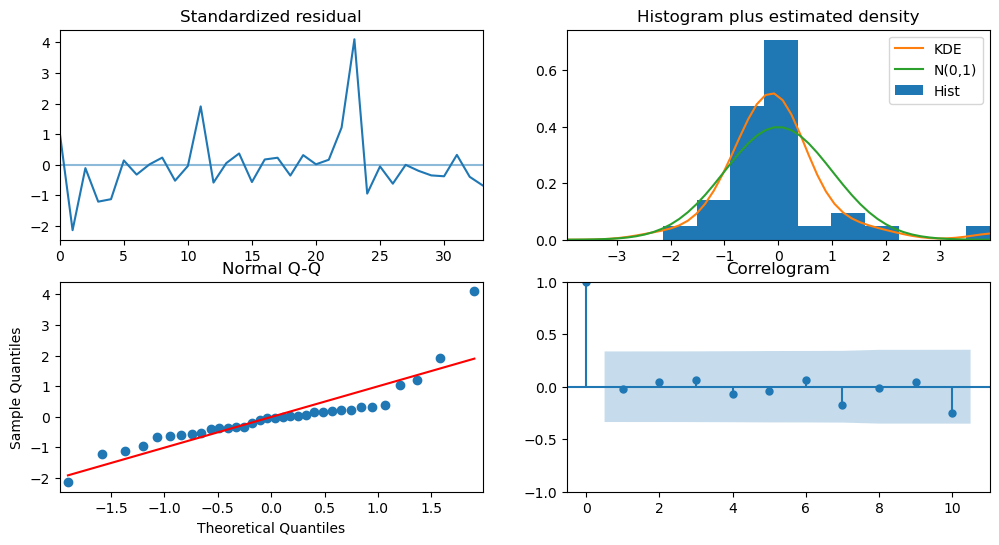

In [35]:
with plt.rc_context():
    plt.rc("figure", figsize=(12, 6))
    model.plot_diagnostics()
    plt.show()

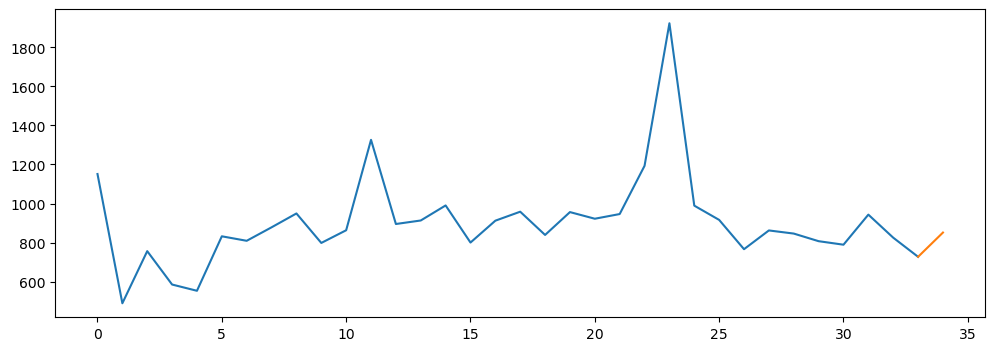

In [50]:
forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))

with plt.rc_context():
    plt.rc("figure", figsize=(12, 4))
    plt.plot(range(trial_ex.shape[0]), trial_ex['item_cnt_month'])
    plt.plot(range(trial_ex.shape[0] - 1, trial_ex.shape[0] + 34 - trial_ex.index[-1]), 
             [trial_ex['item_cnt_month'].iloc[-1], forecast.iloc[-1]])
    plt.show()

### Prediction

In [31]:
shop_lst = train['shop_id'].unique().tolist()
train_origin = pd.read_csv("./data/sales_train.csv")
per = train_origin.groupby(by=["item_id"])["item_cnt_day"].sum().to_frame(name='item_cnt').reset_index()
col = per["item_cnt"].copy()
per["item_per"] = col / col.sum()
pre_df  = pd.DataFrame(columns=["shop_id", "item_id", "item_cnt_month"])

for i in range(len(shop_lst)):
    trial_ex = trial[trial['shop_id'] == shop_lst[i]].drop(columns=['shop_id'])
    model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
    forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))
    try:
        forecast = forecast.iloc[-1]
    except:
        forecast = trial_ex.iloc[0, -1]
    per_example = per[per['item_id'].isin(test.loc[(test['shop_id'] == shop_lst[i]), 'item_id'].unique().tolist())]
    per_example['item_cnt_month'] = per_example['item_per'] * forecast
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] > 20, 20, per_example['item_cnt_month'])
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] < 0, 0, per_example['item_cnt_month'])
    per_example['shop_id'] = shop_lst[i]
    per_example = per_example.drop(columns=["item_per", "item_cnt"])
    pre_df = pd.concat([pre_df, per_example], axis=0)
    
pre_df

/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

,shop_id,item_id,item_cnt_month
30,59,30,0.453507
31,59,31,0.311528
32,59,32,0.454159
33,59,33,0.181490
38,59,38,0.014328
...,...,...,...
21799,36,22162,0.063803
21800,36,22163,0.006846
21801,36,22164,0.045000
21803,36,22166,0.031765


In [35]:
test_arima = pd.merge(test, pre_df, on=['shop_id', 'item_id'], how = "left")
test_arima = test_arima.fillna(value=test_arima['item_cnt_month'].mean())
# test_arima = test_arima.fillna(0)
test_arima 

,ID,shop_id,item_id,item_category_id,date_block_num,price_m,item_cnt_month
0,0,5,5037,19,34,1499.000000,0.428533
1,1,5,5320,55,34,445.207669,0.000000
2,2,5,5233,19,34,1199.000000,0.171076
3,3,5,5232,23,34,1190.433333,0.047577
4,4,5,5268,20,34,445.207669,0.000000
...,...,...,...,...,...,...,...
214195,214195,45,18454,55,34,99.000000,0.087680
214196,214196,45,16188,64,34,1359.000000,0.000678
214197,214197,45,15757,55,34,229.000000,0.062750
214198,214198,45,19648,40,34,89.100000,0.009497


In [36]:
test_arima.isna().sum()

ID                  0
shop_id             0
item_id             0
item_category_id    0
date_block_num      0
price_m             0
item_cnt_month      0
dtype: int64

In [37]:
test_arima = test_arima.loc[:, ['ID', 'item_cnt_month']]
test_arima.to_csv('./results/submission_4.csv', index=False)

## Model Stacking

In [3]:
# Load data
train_X = np.load("./data/train_X.npy")
train_y = np.load("./data/train_y.npy")
test_X = np.load("./data/test_X.npy")

In [15]:
index = np.argmax(train_X[:, 0] > 32)
X_tr = train_X[:index, :]
y_tr = train_y[:index]
X_va = train_X[index:, :]
y_va = train_y[index:]

In [56]:
#######
X_tr = train[train['date_block_num'] < 33]
X_va = train[train['date_block_num'] == 33]

In [60]:
index = X_tr.shape[0]
y_tr = train_y[:index]
y_va = train_y[index:]

In [68]:
# CatBoost 
train_pool = Pool(X_tr, y_tr) 
val_pool = Pool(X_va, y_va) 

model = CatBoostRegressor(early_stopping_rounds=5)
model.fit(train_pool, early_stopping_rounds=5)
pred_va = model.predict(val_pool)
print(mean_squared_error(y_va, pred_va, squared=False))

Learning rate set to 0.131058
0:	learn: 2.5027065	total: 209ms	remaining: 3m 28s
1:	learn: 2.4434453	total: 354ms	remaining: 2m 56s
2:	learn: 2.3941162	total: 479ms	remaining: 2m 39s
3:	learn: 2.3538456	total: 586ms	remaining: 2m 25s
4:	learn: 2.3193861	total: 686ms	remaining: 2m 16s
5:	learn: 2.2902682	total: 803ms	remaining: 2m 13s
6:	learn: 2.2665267	total: 917ms	remaining: 2m 10s
7:	learn: 2.2475111	total: 1.02s	remaining: 2m 6s
8:	learn: 2.2312346	total: 1.13s	remaining: 2m 3s
9:	learn: 2.2142566	total: 1.24s	remaining: 2m 2s
10:	learn: 2.2000666	total: 1.32s	remaining: 1m 59s
11:	learn: 2.1895862	total: 1.4s	remaining: 1m 55s
12:	learn: 2.1786091	total: 1.48s	remaining: 1m 52s
13:	learn: 2.1700302	total: 1.55s	remaining: 1m 49s
14:	learn: 2.1591832	total: 1.62s	remaining: 1m 46s
15:	learn: 2.1529466	total: 1.69s	remaining: 1m 43s
16:	learn: 2.1440890	total: 1.76s	remaining: 1m 41s
17:	learn: 2.1364520	total: 1.83s	remaining: 1m 40s
18:	learn: 2.1286475	total: 1.91s	remaining: 1m 

159:	learn: 1.9025934	total: 13.2s	remaining: 1m 9s
160:	learn: 1.9020215	total: 13.3s	remaining: 1m 9s
161:	learn: 1.9014731	total: 13.3s	remaining: 1m 8s
162:	learn: 1.9005559	total: 13.4s	remaining: 1m 8s
163:	learn: 1.9001531	total: 13.4s	remaining: 1m 8s
164:	learn: 1.8995689	total: 13.5s	remaining: 1m 8s
165:	learn: 1.8990623	total: 13.6s	remaining: 1m 8s
166:	learn: 1.8985826	total: 13.7s	remaining: 1m 8s
167:	learn: 1.8978765	total: 13.7s	remaining: 1m 8s
168:	learn: 1.8972501	total: 13.8s	remaining: 1m 7s
169:	learn: 1.8965868	total: 13.9s	remaining: 1m 7s
170:	learn: 1.8961680	total: 14s	remaining: 1m 7s
171:	learn: 1.8956121	total: 14.1s	remaining: 1m 7s
172:	learn: 1.8952655	total: 14.2s	remaining: 1m 7s
173:	learn: 1.8944155	total: 14.3s	remaining: 1m 8s
174:	learn: 1.8939090	total: 14.5s	remaining: 1m 8s
175:	learn: 1.8930921	total: 14.6s	remaining: 1m 8s
176:	learn: 1.8925607	total: 14.8s	remaining: 1m 8s
177:	learn: 1.8921221	total: 14.9s	remaining: 1m 8s
178:	learn: 1.

320:	learn: 1.8259813	total: 26.2s	remaining: 55.3s
321:	learn: 1.8255257	total: 26.2s	remaining: 55.2s
322:	learn: 1.8251949	total: 26.3s	remaining: 55.1s
323:	learn: 1.8247565	total: 26.4s	remaining: 55s
324:	learn: 1.8246200	total: 26.4s	remaining: 54.9s
325:	learn: 1.8243031	total: 26.5s	remaining: 54.8s
326:	learn: 1.8240080	total: 26.6s	remaining: 54.7s
327:	learn: 1.8236602	total: 26.7s	remaining: 54.6s
328:	learn: 1.8233763	total: 26.7s	remaining: 54.5s
329:	learn: 1.8231840	total: 26.8s	remaining: 54.4s
330:	learn: 1.8227727	total: 26.9s	remaining: 54.3s
331:	learn: 1.8223563	total: 26.9s	remaining: 54.2s
332:	learn: 1.8218952	total: 27s	remaining: 54.1s
333:	learn: 1.8215143	total: 27.1s	remaining: 54s
334:	learn: 1.8211145	total: 27.1s	remaining: 53.9s
335:	learn: 1.8207057	total: 27.2s	remaining: 53.7s
336:	learn: 1.8202944	total: 27.3s	remaining: 53.6s
337:	learn: 1.8198562	total: 27.3s	remaining: 53.5s
338:	learn: 1.8196269	total: 27.4s	remaining: 53.4s
339:	learn: 1.8194

480:	learn: 1.7792873	total: 37.4s	remaining: 40.3s
481:	learn: 1.7790624	total: 37.4s	remaining: 40.2s
482:	learn: 1.7787657	total: 37.5s	remaining: 40.2s
483:	learn: 1.7784943	total: 37.6s	remaining: 40.1s
484:	learn: 1.7782785	total: 37.6s	remaining: 40s
485:	learn: 1.7779951	total: 37.7s	remaining: 39.9s
486:	learn: 1.7778183	total: 37.8s	remaining: 39.8s
487:	learn: 1.7776514	total: 37.8s	remaining: 39.7s
488:	learn: 1.7774415	total: 37.9s	remaining: 39.6s
489:	learn: 1.7772663	total: 37.9s	remaining: 39.5s
490:	learn: 1.7768637	total: 38s	remaining: 39.4s
491:	learn: 1.7765765	total: 38s	remaining: 39.3s
492:	learn: 1.7763855	total: 38.1s	remaining: 39.2s
493:	learn: 1.7760765	total: 38.2s	remaining: 39.1s
494:	learn: 1.7758424	total: 38.2s	remaining: 39s
495:	learn: 1.7757055	total: 38.3s	remaining: 38.9s
496:	learn: 1.7755281	total: 38.3s	remaining: 38.8s
497:	learn: 1.7754128	total: 38.4s	remaining: 38.7s
498:	learn: 1.7752272	total: 38.5s	remaining: 38.6s
499:	learn: 1.775015

639:	learn: 1.7456538	total: 50s	remaining: 28.1s
640:	learn: 1.7455053	total: 50s	remaining: 28s
641:	learn: 1.7453464	total: 50.1s	remaining: 27.9s
642:	learn: 1.7450807	total: 50.2s	remaining: 27.8s
643:	learn: 1.7449867	total: 50.2s	remaining: 27.8s
644:	learn: 1.7446788	total: 50.3s	remaining: 27.7s
645:	learn: 1.7445410	total: 50.4s	remaining: 27.6s
646:	learn: 1.7443861	total: 50.4s	remaining: 27.5s
647:	learn: 1.7441206	total: 50.5s	remaining: 27.4s
648:	learn: 1.7438497	total: 50.6s	remaining: 27.3s
649:	learn: 1.7435271	total: 50.6s	remaining: 27.3s
650:	learn: 1.7432030	total: 50.7s	remaining: 27.2s
651:	learn: 1.7429948	total: 50.8s	remaining: 27.1s
652:	learn: 1.7427863	total: 50.8s	remaining: 27s
653:	learn: 1.7425538	total: 50.9s	remaining: 26.9s
654:	learn: 1.7422938	total: 51s	remaining: 26.9s
655:	learn: 1.7422033	total: 51s	remaining: 26.8s
656:	learn: 1.7419199	total: 51.1s	remaining: 26.7s
657:	learn: 1.7417910	total: 51.2s	remaining: 26.6s
658:	learn: 1.7415575	to

801:	learn: 1.7176409	total: 1m 2s	remaining: 15.5s
802:	learn: 1.7174620	total: 1m 2s	remaining: 15.4s
803:	learn: 1.7171972	total: 1m 2s	remaining: 15.3s
804:	learn: 1.7170977	total: 1m 2s	remaining: 15.2s
805:	learn: 1.7169818	total: 1m 2s	remaining: 15.1s
806:	learn: 1.7169048	total: 1m 3s	remaining: 15.1s
807:	learn: 1.7168357	total: 1m 3s	remaining: 15s
808:	learn: 1.7163177	total: 1m 3s	remaining: 14.9s
809:	learn: 1.7160678	total: 1m 3s	remaining: 14.8s
810:	learn: 1.7159802	total: 1m 3s	remaining: 14.8s
811:	learn: 1.7158207	total: 1m 3s	remaining: 14.7s
812:	learn: 1.7154773	total: 1m 3s	remaining: 14.6s
813:	learn: 1.7153680	total: 1m 3s	remaining: 14.5s
814:	learn: 1.7151284	total: 1m 3s	remaining: 14.4s
815:	learn: 1.7148850	total: 1m 3s	remaining: 14.4s
816:	learn: 1.7147722	total: 1m 3s	remaining: 14.3s
817:	learn: 1.7146182	total: 1m 3s	remaining: 14.2s
818:	learn: 1.7143125	total: 1m 3s	remaining: 14.1s
819:	learn: 1.7140892	total: 1m 3s	remaining: 14s
820:	learn: 1.71

960:	learn: 1.6941217	total: 1m 13s	remaining: 3s
961:	learn: 1.6940482	total: 1m 13s	remaining: 2.92s
962:	learn: 1.6939697	total: 1m 13s	remaining: 2.84s
963:	learn: 1.6937464	total: 1m 14s	remaining: 2.76s
964:	learn: 1.6935886	total: 1m 14s	remaining: 2.69s
965:	learn: 1.6934246	total: 1m 14s	remaining: 2.61s
966:	learn: 1.6933127	total: 1m 14s	remaining: 2.54s
967:	learn: 1.6931816	total: 1m 14s	remaining: 2.46s
968:	learn: 1.6929982	total: 1m 14s	remaining: 2.38s
969:	learn: 1.6929227	total: 1m 14s	remaining: 2.3s
970:	learn: 1.6928086	total: 1m 14s	remaining: 2.23s
971:	learn: 1.6927060	total: 1m 14s	remaining: 2.15s
972:	learn: 1.6924680	total: 1m 14s	remaining: 2.07s
973:	learn: 1.6923826	total: 1m 14s	remaining: 2s
974:	learn: 1.6922931	total: 1m 14s	remaining: 1.92s
975:	learn: 1.6922025	total: 1m 14s	remaining: 1.84s
976:	learn: 1.6921213	total: 1m 14s	remaining: 1.76s
977:	learn: 1.6920198	total: 1m 15s	remaining: 1.69s
978:	learn: 1.6919201	total: 1m 15s	remaining: 1.61s


In [67]:
# XGBoost
model = xgb.XGBRegressor(n_estimators=5000, 
                         max_depth=10, 
                         early_stopping_rounds=10,
                         eval_metric="rmse",
                         learning_rate=0.1,
                         subsample=0.5,
                         colsample_bytree=0.5)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=True)
pred_va = model.predict(X_va)
print(mean_squared_error(y_va, pred_va, squared=False))

[0]	validation_0-rmse:2.85387	validation_1-rmse:2.79800
[1]	validation_0-rmse:2.71013	validation_1-rmse:2.67146
[2]	validation_0-rmse:2.58818	validation_1-rmse:2.56958
[3]	validation_0-rmse:2.48082	validation_1-rmse:2.46920
[4]	validation_0-rmse:2.39605	validation_1-rmse:2.39671
[5]	validation_0-rmse:2.32373	validation_1-rmse:2.33482
[6]	validation_0-rmse:2.26857	validation_1-rmse:2.28416
[7]	validation_0-rmse:2.21676	validation_1-rmse:2.25325
[8]	validation_0-rmse:2.15786	validation_1-rmse:2.21628
[9]	validation_0-rmse:2.11840	validation_1-rmse:2.18321
[10]	validation_0-rmse:2.08438	validation_1-rmse:2.15833
[11]	validation_0-rmse:2.05536	validation_1-rmse:2.13821
[12]	validation_0-rmse:2.01982	validation_1-rmse:2.11977
[13]	validation_0-rmse:1.98903	validation_1-rmse:2.10107
[14]	validation_0-rmse:1.96840	validation_1-rmse:2.07549
[15]	validation_0-rmse:1.95369	validation_1-rmse:2.05710
[16]	validation_0-rmse:1.93857	validation_1-rmse:2.04441
[17]	validation_0-rmse:1.92267	validation

In [69]:
# LightGBM
param = {'metric': 'rmse', 'learning_rate': 0.1}
model = lgb.train(param, lgb.Dataset(X_tr, label=y_tr))
pred_va = model.predict(X_va)
print(mean_squared_error(y_va, pred_va, squared=False))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 1577593, number of used features: 37
[LightGBM] [Info] Start training from score 2.028160
1.941138017957318


In [70]:
# Stacking
final_estimator = GradientBoostingRegressor()
param = {'metric': 'rmse', 'learning_rate': 0.1}
estimators = [('cat', CatBoostRegressor(early_stopping_rounds=3)),
              ('xgb', xgb.XGBRegressor()),
              ('lgb', lgb.LGBMRegressor()),
              ('lasso', linear_model.Lasso()),
              ('ridge',linear_model.Ridge())]
model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
model.fit(X_tr, y_tr)
pred_va = model.predict(X_va)
print(f'rmse: {mean_squared_error(y_va, pred_va, squared=False)}.')

Learning rate set to 0.131058
0:	learn: 2.5027065	total: 149ms	remaining: 2m 28s
1:	learn: 2.4434453	total: 301ms	remaining: 2m 30s
2:	learn: 2.3941162	total: 444ms	remaining: 2m 27s
3:	learn: 2.3538456	total: 580ms	remaining: 2m 24s
4:	learn: 2.3193861	total: 694ms	remaining: 2m 18s
5:	learn: 2.2902682	total: 772ms	remaining: 2m 7s
6:	learn: 2.2665267	total: 847ms	remaining: 2m
7:	learn: 2.2475111	total: 928ms	remaining: 1m 55s
8:	learn: 2.2312346	total: 1s	remaining: 1m 50s
9:	learn: 2.2142566	total: 1.08s	remaining: 1m 46s
10:	learn: 2.2000666	total: 1.16s	remaining: 1m 44s
11:	learn: 2.1895862	total: 1.23s	remaining: 1m 41s
12:	learn: 2.1786091	total: 1.32s	remaining: 1m 39s
13:	learn: 2.1700302	total: 1.4s	remaining: 1m 38s
14:	learn: 2.1591832	total: 1.46s	remaining: 1m 36s
15:	learn: 2.1529466	total: 1.53s	remaining: 1m 33s
16:	learn: 2.1440890	total: 1.6s	remaining: 1m 32s
17:	learn: 2.1364520	total: 1.67s	remaining: 1m 31s
18:	learn: 2.1286475	total: 1.76s	remaining: 1m 30s
19

159:	learn: 1.9025934	total: 12.5s	remaining: 1m 5s
160:	learn: 1.9020215	total: 12.6s	remaining: 1m 5s
161:	learn: 1.9014731	total: 12.6s	remaining: 1m 5s
162:	learn: 1.9005559	total: 12.7s	remaining: 1m 5s
163:	learn: 1.9001531	total: 12.7s	remaining: 1m 4s
164:	learn: 1.8995689	total: 12.8s	remaining: 1m 4s
165:	learn: 1.8990623	total: 12.8s	remaining: 1m 4s
166:	learn: 1.8985826	total: 12.9s	remaining: 1m 4s
167:	learn: 1.8978765	total: 13s	remaining: 1m 4s
168:	learn: 1.8972501	total: 13s	remaining: 1m 4s
169:	learn: 1.8965868	total: 13.1s	remaining: 1m 3s
170:	learn: 1.8961680	total: 13.1s	remaining: 1m 3s
171:	learn: 1.8956121	total: 13.2s	remaining: 1m 3s
172:	learn: 1.8952655	total: 13.3s	remaining: 1m 3s
173:	learn: 1.8944155	total: 13.3s	remaining: 1m 3s
174:	learn: 1.8939090	total: 13.4s	remaining: 1m 2s
175:	learn: 1.8930921	total: 13.4s	remaining: 1m 2s
176:	learn: 1.8925607	total: 13.5s	remaining: 1m 2s
177:	learn: 1.8921221	total: 13.5s	remaining: 1m 2s
178:	learn: 1.89

321:	learn: 1.8255257	total: 23.1s	remaining: 48.7s
322:	learn: 1.8251949	total: 23.2s	remaining: 48.6s
323:	learn: 1.8247565	total: 23.3s	remaining: 48.6s
324:	learn: 1.8246200	total: 23.3s	remaining: 48.5s
325:	learn: 1.8243031	total: 23.4s	remaining: 48.4s
326:	learn: 1.8240080	total: 23.5s	remaining: 48.3s
327:	learn: 1.8236602	total: 23.5s	remaining: 48.2s
328:	learn: 1.8233763	total: 23.6s	remaining: 48.1s
329:	learn: 1.8231840	total: 23.7s	remaining: 48s
330:	learn: 1.8227727	total: 23.7s	remaining: 47.9s
331:	learn: 1.8223563	total: 23.8s	remaining: 47.9s
332:	learn: 1.8218952	total: 23.9s	remaining: 47.8s
333:	learn: 1.8215143	total: 23.9s	remaining: 47.7s
334:	learn: 1.8211145	total: 24s	remaining: 47.6s
335:	learn: 1.8207057	total: 24s	remaining: 47.5s
336:	learn: 1.8202944	total: 24.1s	remaining: 47.4s
337:	learn: 1.8198562	total: 24.2s	remaining: 47.4s
338:	learn: 1.8196269	total: 24.2s	remaining: 47.3s
339:	learn: 1.8194565	total: 24.3s	remaining: 47.2s
340:	learn: 1.8189

481:	learn: 1.7790624	total: 34.4s	remaining: 37s
482:	learn: 1.7787657	total: 34.5s	remaining: 37s
483:	learn: 1.7784943	total: 34.6s	remaining: 36.9s
484:	learn: 1.7782785	total: 34.7s	remaining: 36.8s
485:	learn: 1.7779951	total: 34.7s	remaining: 36.7s
486:	learn: 1.7778183	total: 34.8s	remaining: 36.7s
487:	learn: 1.7776514	total: 34.9s	remaining: 36.6s
488:	learn: 1.7774415	total: 34.9s	remaining: 36.5s
489:	learn: 1.7772663	total: 35s	remaining: 36.4s
490:	learn: 1.7768637	total: 35.1s	remaining: 36.4s
491:	learn: 1.7765765	total: 35.2s	remaining: 36.3s
492:	learn: 1.7763855	total: 35.3s	remaining: 36.3s
493:	learn: 1.7760765	total: 35.3s	remaining: 36.2s
494:	learn: 1.7758424	total: 35.4s	remaining: 36.1s
495:	learn: 1.7757055	total: 35.5s	remaining: 36.1s
496:	learn: 1.7755281	total: 35.6s	remaining: 36s
497:	learn: 1.7754128	total: 35.6s	remaining: 35.9s
498:	learn: 1.7752272	total: 35.7s	remaining: 35.9s
499:	learn: 1.7750154	total: 35.8s	remaining: 35.8s
500:	learn: 1.774895

642:	learn: 1.7450807	total: 46.8s	remaining: 26s
643:	learn: 1.7449867	total: 46.8s	remaining: 25.9s
644:	learn: 1.7446788	total: 46.9s	remaining: 25.8s
645:	learn: 1.7445410	total: 47s	remaining: 25.7s
646:	learn: 1.7443861	total: 47s	remaining: 25.7s
647:	learn: 1.7441206	total: 47.1s	remaining: 25.6s
648:	learn: 1.7438497	total: 47.2s	remaining: 25.5s
649:	learn: 1.7435271	total: 47.2s	remaining: 25.4s
650:	learn: 1.7432030	total: 47.3s	remaining: 25.4s
651:	learn: 1.7429948	total: 47.4s	remaining: 25.3s
652:	learn: 1.7427863	total: 47.4s	remaining: 25.2s
653:	learn: 1.7425538	total: 47.5s	remaining: 25.1s
654:	learn: 1.7422938	total: 47.6s	remaining: 25.1s
655:	learn: 1.7422033	total: 47.6s	remaining: 25s
656:	learn: 1.7419199	total: 47.7s	remaining: 24.9s
657:	learn: 1.7417910	total: 47.8s	remaining: 24.8s
658:	learn: 1.7415575	total: 47.8s	remaining: 24.7s
659:	learn: 1.7414111	total: 47.9s	remaining: 24.7s
660:	learn: 1.7412674	total: 47.9s	remaining: 24.6s
661:	learn: 1.740934

801:	learn: 1.7176409	total: 59s	remaining: 14.6s
802:	learn: 1.7174620	total: 59.1s	remaining: 14.5s
803:	learn: 1.7171972	total: 59.2s	remaining: 14.4s
804:	learn: 1.7170977	total: 59.2s	remaining: 14.3s
805:	learn: 1.7169818	total: 59.3s	remaining: 14.3s
806:	learn: 1.7169048	total: 59.4s	remaining: 14.2s
807:	learn: 1.7168357	total: 59.4s	remaining: 14.1s
808:	learn: 1.7163177	total: 59.5s	remaining: 14.1s
809:	learn: 1.7160678	total: 59.6s	remaining: 14s
810:	learn: 1.7159802	total: 59.6s	remaining: 13.9s
811:	learn: 1.7158207	total: 59.7s	remaining: 13.8s
812:	learn: 1.7154773	total: 59.8s	remaining: 13.8s
813:	learn: 1.7153680	total: 59.9s	remaining: 13.7s
814:	learn: 1.7151284	total: 1m	remaining: 13.6s
815:	learn: 1.7148850	total: 1m	remaining: 13.6s
816:	learn: 1.7147722	total: 1m	remaining: 13.5s
817:	learn: 1.7146182	total: 1m	remaining: 13.4s
818:	learn: 1.7143125	total: 1m	remaining: 13.3s
819:	learn: 1.7140892	total: 1m	remaining: 13.3s
820:	learn: 1.7139116	total: 1m	re

961:	learn: 1.6940482	total: 1m 10s	remaining: 2.8s
962:	learn: 1.6939697	total: 1m 10s	remaining: 2.72s
963:	learn: 1.6937464	total: 1m 10s	remaining: 2.65s
964:	learn: 1.6935886	total: 1m 10s	remaining: 2.57s
965:	learn: 1.6934246	total: 1m 11s	remaining: 2.5s
966:	learn: 1.6933127	total: 1m 11s	remaining: 2.43s
967:	learn: 1.6931816	total: 1m 11s	remaining: 2.35s
968:	learn: 1.6929982	total: 1m 11s	remaining: 2.28s
969:	learn: 1.6929227	total: 1m 11s	remaining: 2.21s
970:	learn: 1.6928086	total: 1m 11s	remaining: 2.13s
971:	learn: 1.6927060	total: 1m 11s	remaining: 2.06s
972:	learn: 1.6924680	total: 1m 11s	remaining: 1.99s
973:	learn: 1.6923826	total: 1m 11s	remaining: 1.91s
974:	learn: 1.6922931	total: 1m 11s	remaining: 1.84s
975:	learn: 1.6922025	total: 1m 11s	remaining: 1.76s
976:	learn: 1.6921213	total: 1m 11s	remaining: 1.69s
977:	learn: 1.6920198	total: 1m 11s	remaining: 1.62s
978:	learn: 1.6919201	total: 1m 12s	remaining: 1.54s
979:	learn: 1.6917310	total: 1m 12s	remaining: 1

124:	learn: 1.8951370	total: 6.78s	remaining: 47.5s
125:	learn: 1.8946752	total: 6.83s	remaining: 47.4s
126:	learn: 1.8938174	total: 6.89s	remaining: 47.3s
127:	learn: 1.8926537	total: 6.94s	remaining: 47.3s
128:	learn: 1.8918116	total: 7s	remaining: 47.2s
129:	learn: 1.8908713	total: 7.05s	remaining: 47.2s
130:	learn: 1.8897407	total: 7.12s	remaining: 47.2s
131:	learn: 1.8889401	total: 7.17s	remaining: 47.1s
132:	learn: 1.8882066	total: 7.23s	remaining: 47.1s
133:	learn: 1.8871090	total: 7.28s	remaining: 47.1s
134:	learn: 1.8857812	total: 7.34s	remaining: 47s
135:	learn: 1.8849806	total: 7.39s	remaining: 46.9s
136:	learn: 1.8842881	total: 7.45s	remaining: 46.9s
137:	learn: 1.8835954	total: 7.5s	remaining: 46.8s
138:	learn: 1.8823885	total: 7.56s	remaining: 46.8s
139:	learn: 1.8817329	total: 7.61s	remaining: 46.8s
140:	learn: 1.8809863	total: 7.67s	remaining: 46.8s
141:	learn: 1.8798710	total: 7.73s	remaining: 46.7s
142:	learn: 1.8793411	total: 7.78s	remaining: 46.6s
143:	learn: 1.8786

285:	learn: 1.8005553	total: 15.4s	remaining: 38.5s
286:	learn: 1.8002095	total: 15.5s	remaining: 38.5s
287:	learn: 1.7999076	total: 15.5s	remaining: 38.4s
288:	learn: 1.7992478	total: 15.6s	remaining: 38.4s
289:	learn: 1.7987792	total: 15.7s	remaining: 38.3s
290:	learn: 1.7983449	total: 15.7s	remaining: 38.3s
291:	learn: 1.7980915	total: 15.8s	remaining: 38.2s
292:	learn: 1.7974875	total: 15.8s	remaining: 38.2s
293:	learn: 1.7971900	total: 15.9s	remaining: 38.2s
294:	learn: 1.7966872	total: 16s	remaining: 38.1s
295:	learn: 1.7963980	total: 16s	remaining: 38.1s
296:	learn: 1.7959586	total: 16.1s	remaining: 38.1s
297:	learn: 1.7957389	total: 16.1s	remaining: 38s
298:	learn: 1.7952014	total: 16.2s	remaining: 38s
299:	learn: 1.7947137	total: 16.3s	remaining: 38s
300:	learn: 1.7941105	total: 16.3s	remaining: 37.9s
301:	learn: 1.7936124	total: 16.4s	remaining: 37.9s
302:	learn: 1.7930234	total: 16.5s	remaining: 37.8s
303:	learn: 1.7924270	total: 16.5s	remaining: 37.8s
304:	learn: 1.7922562	

447:	learn: 1.7448632	total: 25.4s	remaining: 31.3s
448:	learn: 1.7446089	total: 25.5s	remaining: 31.2s
449:	learn: 1.7443108	total: 25.5s	remaining: 31.2s
450:	learn: 1.7439023	total: 25.6s	remaining: 31.1s
451:	learn: 1.7436798	total: 25.6s	remaining: 31.1s
452:	learn: 1.7434479	total: 25.7s	remaining: 31s
453:	learn: 1.7432910	total: 25.7s	remaining: 30.9s
454:	learn: 1.7428661	total: 25.8s	remaining: 30.9s
455:	learn: 1.7426456	total: 25.8s	remaining: 30.8s
456:	learn: 1.7423593	total: 25.9s	remaining: 30.8s
457:	learn: 1.7421852	total: 25.9s	remaining: 30.7s
458:	learn: 1.7420146	total: 26s	remaining: 30.6s
459:	learn: 1.7417993	total: 26s	remaining: 30.6s
460:	learn: 1.7414373	total: 26.1s	remaining: 30.5s
461:	learn: 1.7412120	total: 26.1s	remaining: 30.5s
462:	learn: 1.7408812	total: 26.2s	remaining: 30.4s
463:	learn: 1.7405913	total: 26.3s	remaining: 30.3s
464:	learn: 1.7404349	total: 26.3s	remaining: 30.3s
465:	learn: 1.7399233	total: 26.4s	remaining: 30.2s
466:	learn: 1.7397

609:	learn: 1.7065451	total: 34.7s	remaining: 22.2s
610:	learn: 1.7064688	total: 34.8s	remaining: 22.1s
611:	learn: 1.7063322	total: 34.8s	remaining: 22.1s
612:	learn: 1.7062266	total: 34.9s	remaining: 22s
613:	learn: 1.7060676	total: 34.9s	remaining: 22s
614:	learn: 1.7059033	total: 35s	remaining: 21.9s
615:	learn: 1.7056802	total: 35s	remaining: 21.8s
616:	learn: 1.7054252	total: 35.1s	remaining: 21.8s
617:	learn: 1.7052876	total: 35.1s	remaining: 21.7s
618:	learn: 1.7051730	total: 35.2s	remaining: 21.7s
619:	learn: 1.7050884	total: 35.3s	remaining: 21.6s
620:	learn: 1.7049730	total: 35.3s	remaining: 21.6s
621:	learn: 1.7049098	total: 35.4s	remaining: 21.5s
622:	learn: 1.7047510	total: 35.4s	remaining: 21.4s
623:	learn: 1.7045157	total: 35.5s	remaining: 21.4s
624:	learn: 1.7044016	total: 35.5s	remaining: 21.3s
625:	learn: 1.7041987	total: 35.6s	remaining: 21.2s
626:	learn: 1.7039748	total: 35.6s	remaining: 21.2s
627:	learn: 1.7037578	total: 35.7s	remaining: 21.1s
628:	learn: 1.703501

769:	learn: 1.6776302	total: 45.4s	remaining: 13.5s
770:	learn: 1.6772723	total: 45.4s	remaining: 13.5s
771:	learn: 1.6771556	total: 45.5s	remaining: 13.4s
772:	learn: 1.6770462	total: 45.6s	remaining: 13.4s
773:	learn: 1.6767218	total: 45.6s	remaining: 13.3s
774:	learn: 1.6765295	total: 45.7s	remaining: 13.3s
775:	learn: 1.6763747	total: 45.8s	remaining: 13.2s
776:	learn: 1.6761828	total: 45.8s	remaining: 13.2s
777:	learn: 1.6760215	total: 45.9s	remaining: 13.1s
778:	learn: 1.6758990	total: 46s	remaining: 13s
779:	learn: 1.6757850	total: 46s	remaining: 13s
780:	learn: 1.6755042	total: 46.1s	remaining: 12.9s
781:	learn: 1.6753552	total: 46.2s	remaining: 12.9s
782:	learn: 1.6751399	total: 46.2s	remaining: 12.8s
783:	learn: 1.6750678	total: 46.3s	remaining: 12.8s
784:	learn: 1.6749135	total: 46.3s	remaining: 12.7s
785:	learn: 1.6745986	total: 46.4s	remaining: 12.6s
786:	learn: 1.6744332	total: 46.5s	remaining: 12.6s
787:	learn: 1.6742296	total: 46.6s	remaining: 12.5s
788:	learn: 1.673990

928:	learn: 1.6521572	total: 55.2s	remaining: 4.22s
929:	learn: 1.6520285	total: 55.3s	remaining: 4.16s
930:	learn: 1.6519748	total: 55.3s	remaining: 4.1s
931:	learn: 1.6517202	total: 55.4s	remaining: 4.04s
932:	learn: 1.6516084	total: 55.4s	remaining: 3.98s
933:	learn: 1.6515145	total: 55.5s	remaining: 3.92s
934:	learn: 1.6513480	total: 55.5s	remaining: 3.86s
935:	learn: 1.6511819	total: 55.6s	remaining: 3.8s
936:	learn: 1.6510747	total: 55.6s	remaining: 3.74s
937:	learn: 1.6509637	total: 55.7s	remaining: 3.68s
938:	learn: 1.6507952	total: 55.7s	remaining: 3.62s
939:	learn: 1.6507044	total: 55.8s	remaining: 3.56s
940:	learn: 1.6506294	total: 55.8s	remaining: 3.5s
941:	learn: 1.6504962	total: 55.8s	remaining: 3.44s
942:	learn: 1.6503705	total: 55.9s	remaining: 3.38s
943:	learn: 1.6502490	total: 56s	remaining: 3.32s
944:	learn: 1.6501334	total: 56s	remaining: 3.26s
945:	learn: 1.6500525	total: 56.1s	remaining: 3.2s
946:	learn: 1.6499388	total: 56.1s	remaining: 3.14s
947:	learn: 1.649858

90:	learn: 1.9587041	total: 5.54s	remaining: 55.4s
91:	learn: 1.9572095	total: 5.6s	remaining: 55.3s
92:	learn: 1.9563921	total: 5.67s	remaining: 55.3s
93:	learn: 1.9549638	total: 5.73s	remaining: 55.2s
94:	learn: 1.9529855	total: 5.8s	remaining: 55.3s
95:	learn: 1.9522241	total: 5.86s	remaining: 55.2s
96:	learn: 1.9510773	total: 5.92s	remaining: 55.1s
97:	learn: 1.9499375	total: 5.98s	remaining: 55s
98:	learn: 1.9490461	total: 6.03s	remaining: 54.8s
99:	learn: 1.9481352	total: 6.08s	remaining: 54.7s
100:	learn: 1.9470764	total: 6.12s	remaining: 54.5s
101:	learn: 1.9458742	total: 6.18s	remaining: 54.4s
102:	learn: 1.9450725	total: 6.23s	remaining: 54.3s
103:	learn: 1.9442300	total: 6.29s	remaining: 54.2s
104:	learn: 1.9433943	total: 6.34s	remaining: 54s
105:	learn: 1.9416903	total: 6.4s	remaining: 54s
106:	learn: 1.9400742	total: 6.45s	remaining: 53.8s
107:	learn: 1.9395313	total: 6.49s	remaining: 53.6s
108:	learn: 1.9378810	total: 6.55s	remaining: 53.5s
109:	learn: 1.9366801	total: 6.

250:	learn: 1.8460509	total: 14.4s	remaining: 42.9s
251:	learn: 1.8457018	total: 14.4s	remaining: 42.8s
252:	learn: 1.8452054	total: 14.5s	remaining: 42.7s
253:	learn: 1.8449194	total: 14.5s	remaining: 42.7s
254:	learn: 1.8444519	total: 14.6s	remaining: 42.6s
255:	learn: 1.8440128	total: 14.6s	remaining: 42.6s
256:	learn: 1.8436942	total: 14.7s	remaining: 42.5s
257:	learn: 1.8427229	total: 14.8s	remaining: 42.4s
258:	learn: 1.8420081	total: 14.8s	remaining: 42.4s
259:	learn: 1.8412753	total: 14.9s	remaining: 42.3s
260:	learn: 1.8410784	total: 14.9s	remaining: 42.2s
261:	learn: 1.8404127	total: 15s	remaining: 42.2s
262:	learn: 1.8401374	total: 15s	remaining: 42.1s
263:	learn: 1.8398868	total: 15.1s	remaining: 42s
264:	learn: 1.8394266	total: 15.1s	remaining: 42s
265:	learn: 1.8391097	total: 15.2s	remaining: 41.9s
266:	learn: 1.8388325	total: 15.2s	remaining: 41.8s
267:	learn: 1.8382901	total: 15.3s	remaining: 41.8s
268:	learn: 1.8377515	total: 15.3s	remaining: 41.7s
269:	learn: 1.837203

409:	learn: 1.7885442	total: 23.9s	remaining: 34.4s
410:	learn: 1.7880794	total: 24s	remaining: 34.4s
411:	learn: 1.7878195	total: 24.1s	remaining: 34.3s
412:	learn: 1.7876021	total: 24.1s	remaining: 34.3s
413:	learn: 1.7873684	total: 24.2s	remaining: 34.2s
414:	learn: 1.7869801	total: 24.3s	remaining: 34.2s
415:	learn: 1.7868359	total: 24.3s	remaining: 34.1s
416:	learn: 1.7864386	total: 24.4s	remaining: 34.1s
417:	learn: 1.7860699	total: 24.4s	remaining: 34s
418:	learn: 1.7856893	total: 24.5s	remaining: 34s
419:	learn: 1.7854356	total: 24.6s	remaining: 33.9s
420:	learn: 1.7851228	total: 24.6s	remaining: 33.9s
421:	learn: 1.7848737	total: 24.7s	remaining: 33.8s
422:	learn: 1.7846931	total: 24.8s	remaining: 33.8s
423:	learn: 1.7843327	total: 24.8s	remaining: 33.7s
424:	learn: 1.7841788	total: 24.9s	remaining: 33.7s
425:	learn: 1.7836971	total: 25s	remaining: 33.6s
426:	learn: 1.7835138	total: 25s	remaining: 33.5s
427:	learn: 1.7833938	total: 25.1s	remaining: 33.5s
428:	learn: 1.7829743	

570:	learn: 1.7482924	total: 34.2s	remaining: 25.7s
571:	learn: 1.7480598	total: 34.3s	remaining: 25.7s
572:	learn: 1.7478771	total: 34.4s	remaining: 25.6s
573:	learn: 1.7475560	total: 34.4s	remaining: 25.5s
574:	learn: 1.7473890	total: 34.5s	remaining: 25.5s
575:	learn: 1.7471464	total: 34.5s	remaining: 25.4s
576:	learn: 1.7469717	total: 34.6s	remaining: 25.4s
577:	learn: 1.7468497	total: 34.7s	remaining: 25.3s
578:	learn: 1.7466347	total: 34.7s	remaining: 25.2s
579:	learn: 1.7465575	total: 34.8s	remaining: 25.2s
580:	learn: 1.7461564	total: 34.8s	remaining: 25.1s
581:	learn: 1.7455832	total: 34.9s	remaining: 25.1s
582:	learn: 1.7454016	total: 35s	remaining: 25s
583:	learn: 1.7452914	total: 35.1s	remaining: 25s
584:	learn: 1.7450517	total: 35.1s	remaining: 24.9s
585:	learn: 1.7448719	total: 35.2s	remaining: 24.8s
586:	learn: 1.7446948	total: 35.3s	remaining: 24.8s
587:	learn: 1.7445980	total: 35.3s	remaining: 24.7s
588:	learn: 1.7443866	total: 35.4s	remaining: 24.7s
589:	learn: 1.7441

731:	learn: 1.7185054	total: 46.2s	remaining: 16.9s
732:	learn: 1.7183578	total: 46.3s	remaining: 16.9s
733:	learn: 1.7182115	total: 46.3s	remaining: 16.8s
734:	learn: 1.7180017	total: 46.4s	remaining: 16.7s
735:	learn: 1.7178631	total: 46.5s	remaining: 16.7s
736:	learn: 1.7176615	total: 46.6s	remaining: 16.6s
737:	learn: 1.7174525	total: 46.6s	remaining: 16.6s
738:	learn: 1.7172070	total: 46.7s	remaining: 16.5s
739:	learn: 1.7170337	total: 46.8s	remaining: 16.4s
740:	learn: 1.7169375	total: 46.8s	remaining: 16.4s
741:	learn: 1.7167937	total: 46.9s	remaining: 16.3s
742:	learn: 1.7162890	total: 47s	remaining: 16.3s
743:	learn: 1.7159265	total: 47.1s	remaining: 16.2s
744:	learn: 1.7156013	total: 47.1s	remaining: 16.1s
745:	learn: 1.7154393	total: 47.2s	remaining: 16.1s
746:	learn: 1.7153672	total: 47.2s	remaining: 16s
747:	learn: 1.7151049	total: 47.3s	remaining: 15.9s
748:	learn: 1.7150136	total: 47.3s	remaining: 15.9s
749:	learn: 1.7147082	total: 47.4s	remaining: 15.8s
750:	learn: 1.71

892:	learn: 1.6930453	total: 55.9s	remaining: 6.69s
893:	learn: 1.6929288	total: 55.9s	remaining: 6.63s
894:	learn: 1.6928146	total: 56s	remaining: 6.57s
895:	learn: 1.6927355	total: 56.1s	remaining: 6.51s
896:	learn: 1.6925361	total: 56.1s	remaining: 6.45s
897:	learn: 1.6924681	total: 56.2s	remaining: 6.38s
898:	learn: 1.6922335	total: 56.3s	remaining: 6.32s
899:	learn: 1.6921436	total: 56.3s	remaining: 6.26s
900:	learn: 1.6920504	total: 56.4s	remaining: 6.2s
901:	learn: 1.6918906	total: 56.5s	remaining: 6.13s
902:	learn: 1.6917863	total: 56.6s	remaining: 6.08s
903:	learn: 1.6916629	total: 56.6s	remaining: 6.01s
904:	learn: 1.6915498	total: 56.7s	remaining: 5.95s
905:	learn: 1.6914425	total: 56.7s	remaining: 5.89s
906:	learn: 1.6911800	total: 56.8s	remaining: 5.83s
907:	learn: 1.6910939	total: 56.9s	remaining: 5.76s
908:	learn: 1.6910141	total: 56.9s	remaining: 5.7s
909:	learn: 1.6909233	total: 57s	remaining: 5.64s
910:	learn: 1.6907708	total: 57.1s	remaining: 5.58s
911:	learn: 1.6905

52:	learn: 2.0158027	total: 3.71s	remaining: 1m 6s
53:	learn: 2.0142007	total: 3.77s	remaining: 1m 6s
54:	learn: 2.0128678	total: 3.82s	remaining: 1m 5s
55:	learn: 2.0107646	total: 3.87s	remaining: 1m 5s
56:	learn: 2.0089983	total: 3.92s	remaining: 1m 4s
57:	learn: 2.0069195	total: 3.97s	remaining: 1m 4s
58:	learn: 2.0045981	total: 4.03s	remaining: 1m 4s
59:	learn: 2.0025163	total: 4.08s	remaining: 1m 3s
60:	learn: 2.0012962	total: 4.14s	remaining: 1m 3s
61:	learn: 1.9989924	total: 4.19s	remaining: 1m 3s
62:	learn: 1.9966058	total: 4.24s	remaining: 1m 3s
63:	learn: 1.9956102	total: 4.29s	remaining: 1m 2s
64:	learn: 1.9943750	total: 4.35s	remaining: 1m 2s
65:	learn: 1.9923459	total: 4.42s	remaining: 1m 2s
66:	learn: 1.9906046	total: 4.48s	remaining: 1m 2s
67:	learn: 1.9890647	total: 4.54s	remaining: 1m 2s
68:	learn: 1.9876632	total: 4.59s	remaining: 1m 1s
69:	learn: 1.9863050	total: 4.64s	remaining: 1m 1s
70:	learn: 1.9847236	total: 4.7s	remaining: 1m 1s
71:	learn: 1.9839129	total: 4.75

212:	learn: 1.8601456	total: 12.7s	remaining: 46.8s
213:	learn: 1.8596188	total: 12.7s	remaining: 46.7s
214:	learn: 1.8591214	total: 12.8s	remaining: 46.6s
215:	learn: 1.8583598	total: 12.8s	remaining: 46.5s
216:	learn: 1.8579153	total: 12.9s	remaining: 46.5s
217:	learn: 1.8576512	total: 12.9s	remaining: 46.4s
218:	learn: 1.8566183	total: 13s	remaining: 46.3s
219:	learn: 1.8560838	total: 13s	remaining: 46.2s
220:	learn: 1.8554168	total: 13.1s	remaining: 46.2s
221:	learn: 1.8550985	total: 13.1s	remaining: 46.1s
222:	learn: 1.8546816	total: 13.2s	remaining: 46s
223:	learn: 1.8542080	total: 13.3s	remaining: 46s
224:	learn: 1.8539334	total: 13.3s	remaining: 45.9s
225:	learn: 1.8536049	total: 13.4s	remaining: 45.8s
226:	learn: 1.8525349	total: 13.4s	remaining: 45.7s
227:	learn: 1.8522478	total: 13.5s	remaining: 45.6s
228:	learn: 1.8519357	total: 13.5s	remaining: 45.5s
229:	learn: 1.8514009	total: 13.6s	remaining: 45.5s
230:	learn: 1.8508594	total: 13.6s	remaining: 45.4s
231:	learn: 1.850316

374:	learn: 1.7913714	total: 21.3s	remaining: 35.6s
375:	learn: 1.7910047	total: 21.4s	remaining: 35.5s
376:	learn: 1.7907564	total: 21.4s	remaining: 35.4s
377:	learn: 1.7905594	total: 21.5s	remaining: 35.4s
378:	learn: 1.7902946	total: 21.6s	remaining: 35.3s
379:	learn: 1.7899589	total: 21.6s	remaining: 35.3s
380:	learn: 1.7896306	total: 21.7s	remaining: 35.2s
381:	learn: 1.7890642	total: 21.7s	remaining: 35.2s
382:	learn: 1.7886978	total: 21.8s	remaining: 35.1s
383:	learn: 1.7882042	total: 21.9s	remaining: 35.1s
384:	learn: 1.7878855	total: 21.9s	remaining: 35s
385:	learn: 1.7876965	total: 22s	remaining: 34.9s
386:	learn: 1.7873716	total: 22s	remaining: 34.9s
387:	learn: 1.7871905	total: 22.1s	remaining: 34.8s
388:	learn: 1.7865905	total: 22.1s	remaining: 34.8s
389:	learn: 1.7863724	total: 22.2s	remaining: 34.7s
390:	learn: 1.7858793	total: 22.2s	remaining: 34.6s
391:	learn: 1.7856269	total: 22.3s	remaining: 34.6s
392:	learn: 1.7854965	total: 22.3s	remaining: 34.5s
393:	learn: 1.7852

536:	learn: 1.7521569	total: 30.7s	remaining: 26.5s
537:	learn: 1.7520055	total: 30.8s	remaining: 26.4s
538:	learn: 1.7517158	total: 30.8s	remaining: 26.4s
539:	learn: 1.7515640	total: 30.9s	remaining: 26.3s
540:	learn: 1.7514140	total: 30.9s	remaining: 26.3s
541:	learn: 1.7512405	total: 31s	remaining: 26.2s
542:	learn: 1.7511249	total: 31.1s	remaining: 26.1s
543:	learn: 1.7507701	total: 31.1s	remaining: 26.1s
544:	learn: 1.7506011	total: 31.2s	remaining: 26s
545:	learn: 1.7503036	total: 31.3s	remaining: 26s
546:	learn: 1.7500804	total: 31.3s	remaining: 25.9s
547:	learn: 1.7498418	total: 31.4s	remaining: 25.9s
548:	learn: 1.7496679	total: 31.5s	remaining: 25.8s
549:	learn: 1.7494914	total: 31.5s	remaining: 25.8s
550:	learn: 1.7491928	total: 31.6s	remaining: 25.7s
551:	learn: 1.7489094	total: 31.6s	remaining: 25.7s
552:	learn: 1.7485951	total: 31.7s	remaining: 25.6s
553:	learn: 1.7483474	total: 31.8s	remaining: 25.6s
554:	learn: 1.7481459	total: 31.8s	remaining: 25.5s
555:	learn: 1.7479

697:	learn: 1.7179307	total: 40.2s	remaining: 17.4s
698:	learn: 1.7177878	total: 40.3s	remaining: 17.4s
699:	learn: 1.7176221	total: 40.4s	remaining: 17.3s
700:	learn: 1.7174356	total: 40.4s	remaining: 17.2s
701:	learn: 1.7172433	total: 40.5s	remaining: 17.2s
702:	learn: 1.7170699	total: 40.5s	remaining: 17.1s
703:	learn: 1.7168658	total: 40.6s	remaining: 17.1s
704:	learn: 1.7167308	total: 40.6s	remaining: 17s
705:	learn: 1.7166405	total: 40.7s	remaining: 16.9s
706:	learn: 1.7164748	total: 40.7s	remaining: 16.9s
707:	learn: 1.7160921	total: 40.8s	remaining: 16.8s
708:	learn: 1.7158990	total: 40.9s	remaining: 16.8s
709:	learn: 1.7157979	total: 40.9s	remaining: 16.7s
710:	learn: 1.7156954	total: 41s	remaining: 16.6s
711:	learn: 1.7154120	total: 41s	remaining: 16.6s
712:	learn: 1.7152964	total: 41.1s	remaining: 16.5s
713:	learn: 1.7150774	total: 41.1s	remaining: 16.5s
714:	learn: 1.7149033	total: 41.2s	remaining: 16.4s
715:	learn: 1.7147695	total: 41.3s	remaining: 16.4s
716:	learn: 1.7146

857:	learn: 1.6927488	total: 48.9s	remaining: 8.1s
858:	learn: 1.6927023	total: 49s	remaining: 8.04s
859:	learn: 1.6926080	total: 49s	remaining: 7.98s
860:	learn: 1.6925288	total: 49.1s	remaining: 7.92s
861:	learn: 1.6922940	total: 49.1s	remaining: 7.87s
862:	learn: 1.6921730	total: 49.2s	remaining: 7.81s
863:	learn: 1.6920153	total: 49.2s	remaining: 7.75s
864:	learn: 1.6919203	total: 49.3s	remaining: 7.69s
865:	learn: 1.6918431	total: 49.3s	remaining: 7.63s
866:	learn: 1.6917404	total: 49.4s	remaining: 7.58s
867:	learn: 1.6915560	total: 49.5s	remaining: 7.52s
868:	learn: 1.6914116	total: 49.5s	remaining: 7.46s
869:	learn: 1.6911868	total: 49.6s	remaining: 7.41s
870:	learn: 1.6909370	total: 49.6s	remaining: 7.35s
871:	learn: 1.6906811	total: 49.7s	remaining: 7.29s
872:	learn: 1.6905566	total: 49.7s	remaining: 7.24s
873:	learn: 1.6904495	total: 49.8s	remaining: 7.18s
874:	learn: 1.6903202	total: 49.9s	remaining: 7.12s
875:	learn: 1.6901337	total: 49.9s	remaining: 7.07s
876:	learn: 1.690

19:	learn: 2.0987053	total: 1.06s	remaining: 51.9s
20:	learn: 2.0940528	total: 1.12s	remaining: 52.2s
21:	learn: 2.0896969	total: 1.17s	remaining: 52s
22:	learn: 2.0863875	total: 1.22s	remaining: 52s
23:	learn: 2.0822262	total: 1.28s	remaining: 52.1s
24:	learn: 2.0783641	total: 1.34s	remaining: 52.2s
25:	learn: 2.0741470	total: 1.39s	remaining: 52s
26:	learn: 2.0702675	total: 1.44s	remaining: 51.8s
27:	learn: 2.0677389	total: 1.49s	remaining: 51.6s
28:	learn: 2.0644517	total: 1.53s	remaining: 51.3s
29:	learn: 2.0612997	total: 1.58s	remaining: 51.2s
30:	learn: 2.0571786	total: 1.64s	remaining: 51.4s
31:	learn: 2.0524114	total: 1.7s	remaining: 51.6s
32:	learn: 2.0492495	total: 1.76s	remaining: 51.5s
33:	learn: 2.0474580	total: 1.8s	remaining: 51.3s
34:	learn: 2.0454238	total: 1.86s	remaining: 51.2s
35:	learn: 2.0398849	total: 1.91s	remaining: 51.1s
36:	learn: 2.0373026	total: 1.97s	remaining: 51.2s
37:	learn: 2.0353488	total: 2.02s	remaining: 51s
38:	learn: 2.0331456	total: 2.07s	remaini

180:	learn: 1.8636607	total: 9.82s	remaining: 44.4s
181:	learn: 1.8631496	total: 9.87s	remaining: 44.4s
182:	learn: 1.8624904	total: 9.93s	remaining: 44.4s
183:	learn: 1.8618147	total: 9.99s	remaining: 44.3s
184:	learn: 1.8611165	total: 10s	remaining: 44.3s
185:	learn: 1.8605359	total: 10.1s	remaining: 44.2s
186:	learn: 1.8597768	total: 10.2s	remaining: 44.2s
187:	learn: 1.8590264	total: 10.2s	remaining: 44.1s
188:	learn: 1.8584866	total: 10.3s	remaining: 44.1s
189:	learn: 1.8580233	total: 10.3s	remaining: 44s
190:	learn: 1.8574415	total: 10.4s	remaining: 43.9s
191:	learn: 1.8566833	total: 10.4s	remaining: 43.9s
192:	learn: 1.8559703	total: 10.5s	remaining: 43.9s
193:	learn: 1.8553737	total: 10.5s	remaining: 43.8s
194:	learn: 1.8549468	total: 10.6s	remaining: 43.8s
195:	learn: 1.8543988	total: 10.7s	remaining: 43.7s
196:	learn: 1.8540154	total: 10.7s	remaining: 43.7s
197:	learn: 1.8533177	total: 10.8s	remaining: 43.6s
198:	learn: 1.8528233	total: 10.8s	remaining: 43.6s
199:	learn: 1.85

341:	learn: 1.7889488	total: 18.6s	remaining: 35.8s
342:	learn: 1.7887006	total: 18.7s	remaining: 35.7s
343:	learn: 1.7880932	total: 18.7s	remaining: 35.7s
344:	learn: 1.7876542	total: 18.8s	remaining: 35.6s
345:	learn: 1.7873122	total: 18.8s	remaining: 35.6s
346:	learn: 1.7871572	total: 18.9s	remaining: 35.5s
347:	learn: 1.7866953	total: 18.9s	remaining: 35.4s
348:	learn: 1.7864647	total: 19s	remaining: 35.4s
349:	learn: 1.7860559	total: 19s	remaining: 35.3s
350:	learn: 1.7857051	total: 19.1s	remaining: 35.3s
351:	learn: 1.7854915	total: 19.1s	remaining: 35.2s
352:	learn: 1.7851482	total: 19.2s	remaining: 35.2s
353:	learn: 1.7847503	total: 19.2s	remaining: 35.1s
354:	learn: 1.7844335	total: 19.3s	remaining: 35.1s
355:	learn: 1.7841450	total: 19.3s	remaining: 35s
356:	learn: 1.7837862	total: 19.4s	remaining: 34.9s
357:	learn: 1.7834578	total: 19.5s	remaining: 34.9s
358:	learn: 1.7830652	total: 19.5s	remaining: 34.8s
359:	learn: 1.7827011	total: 19.6s	remaining: 34.8s
360:	learn: 1.7822

502:	learn: 1.7427487	total: 28s	remaining: 27.6s
503:	learn: 1.7421090	total: 28s	remaining: 27.6s
504:	learn: 1.7419767	total: 28.1s	remaining: 27.5s
505:	learn: 1.7417186	total: 28.2s	remaining: 27.5s
506:	learn: 1.7414099	total: 28.2s	remaining: 27.4s
507:	learn: 1.7411011	total: 28.3s	remaining: 27.4s
508:	learn: 1.7408348	total: 28.3s	remaining: 27.3s
509:	learn: 1.7406498	total: 28.4s	remaining: 27.3s
510:	learn: 1.7404423	total: 28.5s	remaining: 27.2s
511:	learn: 1.7401808	total: 28.5s	remaining: 27.2s
512:	learn: 1.7398009	total: 28.6s	remaining: 27.1s
513:	learn: 1.7395642	total: 28.6s	remaining: 27.1s
514:	learn: 1.7394196	total: 28.7s	remaining: 27s
515:	learn: 1.7389104	total: 28.8s	remaining: 27s
516:	learn: 1.7385623	total: 28.8s	remaining: 26.9s
517:	learn: 1.7381472	total: 28.9s	remaining: 26.9s
518:	learn: 1.7379999	total: 28.9s	remaining: 26.8s
519:	learn: 1.7377509	total: 29s	remaining: 26.8s
520:	learn: 1.7376160	total: 29.1s	remaining: 26.7s
521:	learn: 1.7372472	

661:	learn: 1.7083388	total: 38.2s	remaining: 19.5s
662:	learn: 1.7081631	total: 38.3s	remaining: 19.5s
663:	learn: 1.7081010	total: 38.3s	remaining: 19.4s
664:	learn: 1.7079760	total: 38.4s	remaining: 19.3s
665:	learn: 1.7078092	total: 38.5s	remaining: 19.3s
666:	learn: 1.7077412	total: 38.5s	remaining: 19.2s
667:	learn: 1.7075477	total: 38.6s	remaining: 19.2s
668:	learn: 1.7074148	total: 38.6s	remaining: 19.1s
669:	learn: 1.7073043	total: 38.7s	remaining: 19s
670:	learn: 1.7069368	total: 38.7s	remaining: 19s
671:	learn: 1.7068262	total: 38.8s	remaining: 18.9s
672:	learn: 1.7066282	total: 38.8s	remaining: 18.9s
673:	learn: 1.7064852	total: 38.9s	remaining: 18.8s
674:	learn: 1.7063373	total: 39s	remaining: 18.8s
675:	learn: 1.7061228	total: 39s	remaining: 18.7s
676:	learn: 1.7058780	total: 39.1s	remaining: 18.6s
677:	learn: 1.7057169	total: 39.1s	remaining: 18.6s
678:	learn: 1.7055956	total: 39.2s	remaining: 18.5s
679:	learn: 1.7054759	total: 39.2s	remaining: 18.5s
680:	learn: 1.705414

821:	learn: 1.6818401	total: 48.3s	remaining: 10.5s
822:	learn: 1.6816815	total: 48.3s	remaining: 10.4s
823:	learn: 1.6814360	total: 48.4s	remaining: 10.3s
824:	learn: 1.6813339	total: 48.5s	remaining: 10.3s
825:	learn: 1.6812570	total: 48.5s	remaining: 10.2s
826:	learn: 1.6810531	total: 48.6s	remaining: 10.2s
827:	learn: 1.6809491	total: 48.7s	remaining: 10.1s
828:	learn: 1.6808527	total: 48.7s	remaining: 10.1s
829:	learn: 1.6806901	total: 48.8s	remaining: 9.99s
830:	learn: 1.6805299	total: 48.9s	remaining: 9.94s
831:	learn: 1.6804061	total: 48.9s	remaining: 9.87s
832:	learn: 1.6802293	total: 49s	remaining: 9.81s
833:	learn: 1.6800715	total: 49s	remaining: 9.76s
834:	learn: 1.6800050	total: 49.1s	remaining: 9.7s
835:	learn: 1.6798609	total: 49.1s	remaining: 9.63s
836:	learn: 1.6797099	total: 49.2s	remaining: 9.58s
837:	learn: 1.6796180	total: 49.2s	remaining: 9.52s
838:	learn: 1.6792325	total: 49.3s	remaining: 9.46s
839:	learn: 1.6791178	total: 49.4s	remaining: 9.4s
840:	learn: 1.6790

980:	learn: 1.6581963	total: 1m	remaining: 1.16s
981:	learn: 1.6578384	total: 1m	remaining: 1.1s
982:	learn: 1.6577543	total: 1m	remaining: 1.04s
983:	learn: 1.6576499	total: 1m	remaining: 982ms
984:	learn: 1.6575649	total: 1m	remaining: 921ms
985:	learn: 1.6573993	total: 1m	remaining: 861ms
986:	learn: 1.6572682	total: 1m	remaining: 800ms
987:	learn: 1.6570957	total: 1m	remaining: 739ms
988:	learn: 1.6570268	total: 1m	remaining: 677ms
989:	learn: 1.6568461	total: 1m	remaining: 616ms
990:	learn: 1.6567851	total: 1m 1s	remaining: 554ms
991:	learn: 1.6566873	total: 1m 1s	remaining: 493ms
992:	learn: 1.6564836	total: 1m 1s	remaining: 432ms
993:	learn: 1.6562864	total: 1m 1s	remaining: 370ms
994:	learn: 1.6562267	total: 1m 1s	remaining: 309ms
995:	learn: 1.6560965	total: 1m 1s	remaining: 247ms
996:	learn: 1.6560072	total: 1m 1s	remaining: 185ms
997:	learn: 1.6558617	total: 1m 1s	remaining: 124ms
998:	learn: 1.6557747	total: 1m 1s	remaining: 61.8ms
999:	learn: 1.6556668	total: 1m 1s	remaini

144:	learn: 1.9534937	total: 8.56s	remaining: 50.5s
145:	learn: 1.9529837	total: 8.61s	remaining: 50.3s
146:	learn: 1.9522624	total: 8.65s	remaining: 50.2s
147:	learn: 1.9517791	total: 8.71s	remaining: 50.1s
148:	learn: 1.9508722	total: 8.75s	remaining: 50s
149:	learn: 1.9502351	total: 8.8s	remaining: 49.9s
150:	learn: 1.9494865	total: 8.85s	remaining: 49.8s
151:	learn: 1.9490773	total: 8.9s	remaining: 49.6s
152:	learn: 1.9482840	total: 8.95s	remaining: 49.5s
153:	learn: 1.9473208	total: 9s	remaining: 49.4s
154:	learn: 1.9466438	total: 9.05s	remaining: 49.3s
155:	learn: 1.9460897	total: 9.09s	remaining: 49.2s
156:	learn: 1.9451394	total: 9.14s	remaining: 49.1s
157:	learn: 1.9441170	total: 9.2s	remaining: 49s
158:	learn: 1.9437469	total: 9.24s	remaining: 48.9s
159:	learn: 1.9428496	total: 9.29s	remaining: 48.8s
160:	learn: 1.9421358	total: 9.33s	remaining: 48.6s
161:	learn: 1.9413623	total: 9.38s	remaining: 48.5s
162:	learn: 1.9406651	total: 9.43s	remaining: 48.4s
163:	learn: 1.9397155	

304:	learn: 1.8620145	total: 17.5s	remaining: 39.8s
305:	learn: 1.8616019	total: 17.5s	remaining: 39.7s
306:	learn: 1.8608476	total: 17.6s	remaining: 39.7s
307:	learn: 1.8603696	total: 17.6s	remaining: 39.6s
308:	learn: 1.8600866	total: 17.7s	remaining: 39.6s
309:	learn: 1.8596374	total: 17.7s	remaining: 39.5s
310:	learn: 1.8588980	total: 17.8s	remaining: 39.4s
311:	learn: 1.8586002	total: 17.8s	remaining: 39.3s
312:	learn: 1.8582267	total: 17.9s	remaining: 39.3s
313:	learn: 1.8577090	total: 17.9s	remaining: 39.2s
314:	learn: 1.8572644	total: 18s	remaining: 39.1s
315:	learn: 1.8566463	total: 18s	remaining: 39s
316:	learn: 1.8560809	total: 18.1s	remaining: 38.9s
317:	learn: 1.8556157	total: 18.1s	remaining: 38.9s
318:	learn: 1.8552113	total: 18.2s	remaining: 38.8s
319:	learn: 1.8547965	total: 18.2s	remaining: 38.7s
320:	learn: 1.8544518	total: 18.3s	remaining: 38.7s
321:	learn: 1.8541460	total: 18.3s	remaining: 38.6s
322:	learn: 1.8538944	total: 18.4s	remaining: 38.5s
323:	learn: 1.8535

464:	learn: 1.8066679	total: 28.5s	remaining: 32.8s
465:	learn: 1.8063807	total: 28.6s	remaining: 32.8s
466:	learn: 1.8060717	total: 28.7s	remaining: 32.7s
467:	learn: 1.8053878	total: 28.7s	remaining: 32.7s
468:	learn: 1.8050465	total: 28.8s	remaining: 32.6s
469:	learn: 1.8046744	total: 28.9s	remaining: 32.6s
470:	learn: 1.8045086	total: 29s	remaining: 32.5s
471:	learn: 1.8041577	total: 29s	remaining: 32.5s
472:	learn: 1.8038942	total: 29.1s	remaining: 32.4s
473:	learn: 1.8036526	total: 29.2s	remaining: 32.4s
474:	learn: 1.8032745	total: 29.3s	remaining: 32.3s
475:	learn: 1.8028602	total: 29.3s	remaining: 32.3s
476:	learn: 1.8026156	total: 29.4s	remaining: 32.2s
477:	learn: 1.8024118	total: 29.5s	remaining: 32.2s
478:	learn: 1.8021573	total: 29.6s	remaining: 32.2s
479:	learn: 1.8018146	total: 29.7s	remaining: 32.1s
480:	learn: 1.8015884	total: 29.7s	remaining: 32.1s
481:	learn: 1.8010649	total: 29.8s	remaining: 32.1s
482:	learn: 1.8008097	total: 29.9s	remaining: 32s
483:	learn: 1.8005

626:	learn: 1.7687039	total: 40s	remaining: 23.8s
627:	learn: 1.7684865	total: 40.1s	remaining: 23.8s
628:	learn: 1.7682115	total: 40.2s	remaining: 23.7s
629:	learn: 1.7680097	total: 40.2s	remaining: 23.6s
630:	learn: 1.7678761	total: 40.3s	remaining: 23.6s
631:	learn: 1.7677422	total: 40.4s	remaining: 23.5s
632:	learn: 1.7673004	total: 40.4s	remaining: 23.4s
633:	learn: 1.7672113	total: 40.5s	remaining: 23.4s
634:	learn: 1.7670258	total: 40.6s	remaining: 23.3s
635:	learn: 1.7667907	total: 40.6s	remaining: 23.3s
636:	learn: 1.7667004	total: 40.7s	remaining: 23.2s
637:	learn: 1.7665300	total: 40.7s	remaining: 23.1s
638:	learn: 1.7663818	total: 40.8s	remaining: 23s
639:	learn: 1.7662273	total: 40.9s	remaining: 23s
640:	learn: 1.7661122	total: 40.9s	remaining: 22.9s
641:	learn: 1.7659930	total: 41s	remaining: 22.8s
642:	learn: 1.7658821	total: 41s	remaining: 22.8s
643:	learn: 1.7657496	total: 41.1s	remaining: 22.7s
644:	learn: 1.7654245	total: 41.1s	remaining: 22.6s
645:	learn: 1.7651676	

785:	learn: 1.7391392	total: 50s	remaining: 13.6s
786:	learn: 1.7390257	total: 50.1s	remaining: 13.5s
787:	learn: 1.7388866	total: 50.1s	remaining: 13.5s
788:	learn: 1.7387705	total: 50.2s	remaining: 13.4s
789:	learn: 1.7386843	total: 50.2s	remaining: 13.3s
790:	learn: 1.7384658	total: 50.3s	remaining: 13.3s
791:	learn: 1.7383572	total: 50.3s	remaining: 13.2s
792:	learn: 1.7382509	total: 50.4s	remaining: 13.1s
793:	learn: 1.7379772	total: 50.4s	remaining: 13.1s
794:	learn: 1.7377522	total: 50.5s	remaining: 13s
795:	learn: 1.7376379	total: 50.5s	remaining: 13s
796:	learn: 1.7374703	total: 50.6s	remaining: 12.9s
797:	learn: 1.7372519	total: 50.6s	remaining: 12.8s
798:	learn: 1.7370419	total: 50.7s	remaining: 12.8s
799:	learn: 1.7367436	total: 50.8s	remaining: 12.7s
800:	learn: 1.7365595	total: 50.8s	remaining: 12.6s
801:	learn: 1.7363914	total: 50.9s	remaining: 12.6s
802:	learn: 1.7361847	total: 50.9s	remaining: 12.5s
803:	learn: 1.7360883	total: 51s	remaining: 12.4s
804:	learn: 1.735831

945:	learn: 1.7141575	total: 59.2s	remaining: 3.38s
946:	learn: 1.7140108	total: 59.2s	remaining: 3.31s
947:	learn: 1.7139034	total: 59.3s	remaining: 3.25s
948:	learn: 1.7138262	total: 59.3s	remaining: 3.19s
949:	learn: 1.7136570	total: 59.4s	remaining: 3.13s
950:	learn: 1.7134607	total: 59.5s	remaining: 3.06s
951:	learn: 1.7133652	total: 59.5s	remaining: 3s
952:	learn: 1.7132525	total: 59.6s	remaining: 2.94s
953:	learn: 1.7131423	total: 59.6s	remaining: 2.87s
954:	learn: 1.7129770	total: 59.7s	remaining: 2.81s
955:	learn: 1.7128857	total: 59.7s	remaining: 2.75s
956:	learn: 1.7128409	total: 59.8s	remaining: 2.68s
957:	learn: 1.7126677	total: 59.8s	remaining: 2.62s
958:	learn: 1.7124554	total: 59.9s	remaining: 2.56s
959:	learn: 1.7123513	total: 59.9s	remaining: 2.5s
960:	learn: 1.7122602	total: 60s	remaining: 2.43s
961:	learn: 1.7121205	total: 1m	remaining: 2.37s
962:	learn: 1.7120536	total: 1m	remaining: 2.31s
963:	learn: 1.7119601	total: 1m	remaining: 2.24s
964:	learn: 1.7118436	total